# LN - Data PP - Graph definition 

## Libraries, data and directory

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import networkx as nx
import itertools
import matplotlib.pyplot as plt

import time
import re
import sys
import io
import random
import pickle
import dask.array as da
from datetime import datetime
import os
import itertools

from tqdm.notebook import trange, tqdm
from time import sleep

import boto3

from dask_cloudprovider import FargateCluster
from dask.distributed import Client
import dask.array as da
import dask
dask.config.set({'distributed.scheduler.allowed-failures': 50})



In [2]:
# Load Data

# Initiate s3 resource

session = boto3.session.Session()
s3 = session.resource('s3')
bucket='ln-strategy-data'



# Dataframe

decisions_load = s3.Object(bucket_name=bucket, key='LN_channels.csv').get()
#decisions_load = s3.Object(bucket_name=bucket, key='decisions_df.csv').get()
df=pd.read_csv(io.BytesIO(decisions_load['Body'].read()))
df.head()

# Channel closures
closure_file = s3.Object(bucket_name=bucket, key='channel_closures.p').get()
channel_closures = pickle.loads(closure_file['Body'].read())
    
    
# Channel openings 
opens_file = s3.Object(bucket_name=bucket, key='channel_opens.p').get()
channel_opens = pickle.loads(opens_file['Body'].read())


In [4]:
# Uncomment for local sql data connection
'''
cnx = sqlite3.connect('./data/LN_channels.db')
df = pd.read_sql_query("SELECT * FROM channels", cnx)
'''

## Connection to AWS - Fargate Clusters

In [ ]:
cluster = FargateCluster(n_workers=100,scheduler_timeout='60 minutes',image='dsrincon/dask-graph:nx-scipy-v1')

In [46]:
cluster

<Client: not connected>

In [47]:
#cluster=Client(cluster)
cluster=Client('tcp://34.204.101.185:8786')

/opt/conda/lib/python3.7/site-packages/distributed/client.py:1079: VersionMismatchWarning: Mismatched versions found

python
+---------------------------+---------------+
|                           | version       |
+---------------------------+---------------+
| client                    | 3.7.3.final.0 |
| scheduler                 | 3.7.4.final.0 |
| tcp://172.31.0.179:38805  | 3.7.4.final.0 |
| tcp://172.31.1.118:33155  | 3.7.4.final.0 |
| tcp://172.31.1.213:33135  | 3.7.4.final.0 |
| tcp://172.31.1.54:39373   | 3.7.4.final.0 |
| tcp://172.31.11.27:36825  | 3.7.4.final.0 |
| tcp://172.31.11.56:41891  | 3.7.4.final.0 |
| tcp://172.31.14.250:39855 | 3.7.4.final.0 |
| tcp://172.31.16.242:33903 | 3.7.4.final.0 |
| tcp://172.31.17.71:36347  | 3.7.4.final.0 |
| tcp://172.31.18.5:43811   | 3.7.4.final.0 |
| tcp://172.31.18.94:36593  | 3.7.4.final.0 |
| tcp://172.31.2.21:39933   | 3.7.4.final.0 |
| tcp://172.31.21.146:37841 | 3.7.4.final.0 |
| tcp://172.31.22.125:41259 | 3.7.4.final.0 |
|

## Extract decisions per blocks

### Create blocks and nodes

In [29]:
# Generate block array with blocks where decisions have taken place. 

# Find blocks where opening decisions have taken place
blocks_open=df.open_block.to_numpy()
blocks_open=np.unique(blocks_open)

# Find blocks where closing deciscions have taken place
blocks_close=df.close_block.to_numpy()
blocks_close=np.nan_to_num(blocks_close)
blocks_close=np.unique(blocks_close)


# Union of blocks with opening and closing decisions
blocks=set(blocks_open).union(blocks_close)
blocks=list(blocks)
blocks=np.sort(np.array(blocks))
blocks=blocks[1:] # N/A will create a block 0 that needs to be removed
blocks=blocks.astype(int)


print('Total blocks with decisions: {}'.format(len(blocks)))

Total blocks with decisions: 36543


In [17]:
# Extract unique nodes, create smaller ids 

# Unique nodes
nodes=set(df.node0).union(set(df.node1))
nodes=list(nodes)

# Create ids and dictionary that relates ids to nodes 
ids=np.arange(len(nodes))
nodes_id={nodes:i for i,nodes in zip(ids,nodes)} # Create dictionary with_node_ids

# Create columns with node ids
df['node0_id']=df['node0']
df['node1_id']=df['node1']
df.replace({'node0_id':nodes_id,'node1_id':nodes_id},inplace=True)

# Sort
df.sort_values(by=['open_block'],inplace=True,ascending=False)

# Create column for node pair 
df['node_pair']=df['node0_id']*df['node1_id']


print('Total nodes: {}'.format(len(nodes)))

df.head()

Total nodes: 7735


,short_channel_id,open_block,open_transaction,address,close_block,close_transaction,node0,node1,satoshis,last_seen,...,close_fee,last_update,close_type,close_htlc_count,close_balance_a,close_balance_b,dec_id,node0_id,node1_id,node_pair
72475,617297x720x0,617297,5aa10236396e6f1118806e0725572e3681f750a39401d1...,bc1qxklh2cq63d4s9pn0lmv9n04k9ly7ndhny4d848d950...,NaN,NaN,029bf3edd752470fb554330e8d40f7f10d73e9f9838898...,02da8d5a759ee9e4438da617cfdb61c87f723fb76c4b63...,1000000,2020-02-14 06:45:28,...,NaN,1.581649e+09,NaN,NaN,NaN,NaN,72475,5161,7141,36854701
72473,617295x550x0,617295,3a52a4d6dc06418c9477d34c4ee834b46c6bd6e0a55b12...,bc1qc46akgl8s3le5g038n92ha90rm666u397gs6s5tmzh...,NaN,NaN,0237fefbe8626bf888de0cad8c73630e32746a22a2c4fa...,033edf115cbd38a6803d2912904c33d45df0d3c74a35dd...,95675,2020-02-14 06:45:25,...,NaN,1.581648e+09,NaN,NaN,NaN,NaN,72473,135,7083,956205
72474,617295x1743x1,617295,0290e91d1007d8fb42c6a30c04af298337ea5e7833bc9e...,bc1qmadhqrsk77pgtpgt4k34hnjaysk290vfgsw2hua7p7...,NaN,NaN,028737303e12cb84643d1f0181812b559a56ef5d78b4c4...,03a503d8e30f2ff407096d235b5db63b4fcf3f89a653ac...,500000,2020-02-14 06:45:26,...,NaN,1.581648e+09,NaN,NaN,NaN,NaN,72474,7524,1232,9269568
72472,617294x894x0,617294,801ef73a0e237275b81a625362b3173bcbea7aac0af280...,bc1q46yvjxf0dth8qwnlhzs00kczztgf38eh74eh6x5uec...,NaN,NaN,031567fdf33cb9b4ab081019199295ffce38218751842a...,033edf115cbd38a6803d2912904c33d45df0d3c74a35dd...,95675,2020-02-14 06:45:24,...,NaN,1.581648e+09,NaN,NaN,NaN,NaN,72472,2205,7083,15618015
72470,617292x63x0,617292,557aaea396b8967031803fa8119fef9a17611229b7aea1...,bc1qw9vetekdv2kaw0gh4w5m60xdrwz968k7pwvw4fuzxy...,NaN,NaN,033edf115cbd38a6803d2912904c33d45df0d3c74a35dd...,03d37fca0656558de4fd86bbe490a38d84a46228e7ec13...,95675,2020-02-14 06:45:22,...,NaN,1.581647e+09,NaN,NaN,NaN,NaN,72470,7083,6270,44410410


In [121]:
df.columns

Index(['short_channel_id', 'open_block', 'open_transaction', 'address',
       'close_block', 'close_transaction', 'node0', 'node1', 'satoshis',
       'last_seen', 'open_time', 'open_fee', 'close_time', 'close_fee',
       'last_update', 'close_type', 'close_htlc_count', 'close_balance_a',
       'close_balance_b', 'dec_id', 'node0_id', 'node1_id', 'node_pair'],
      dtype='object')

In [20]:
# Save transformed DataFrame to S3
key='decisions_df.csv'
response=save_s3(df,bucket,key,'csv')
if response['HTTPStatusCode']==200:
    print('Save to S3 succesful')
else:
    print(response)

Save to S3 succesful


### Extract channel openings

In [21]:
# Generate dictionary of channel openings
channel_opens={}
for b in blocks:
    channel_array=df[df['open_block']==b][['node0_id','node1_id','satoshis','open_fee','dec_id','short_channel_id']].to_numpy()
    list_channels=[(channel[0],channel[1],{'capacity':channel[2],'open_fee':channel[3],'dec_id':channel[4],'channel_id':channel[5],'no_channels':0}) for channel in channel_array]
    channel_opens[b]=list_channels
    


In [22]:
# TESTING: Channel openings
## sum of openings should be equivalent to openings from Data Frame

total_opens=len(df['open_block'])
saved_opens=np.sum(np.array([len(opens) for opens in list(channel_opens.values()) ]))
only_open_dic={b:opens for b,opens in channel_opens.items() if len(opens)>0}
                
print('Total opens:{} '.format(total_opens))
print('Registered opens: {}'.format(saved_opens))

rand_block=random.choice(list(only_open_dic.keys()))
print("Data Sample for 'channel_opens dictionary for block {}'".format(rand_block))
print(channel_opens[rand_block])

Total opens:72476 
Registered opens: 72476
Data Sample for 'channel_opens dictionary for block 579566'
[(2253, 4720, {'capacity': 250000, 'open_fee': 13797, 'dec_id': 38951, 'channel_id': '579566x2139x1', 'no_channels': 0})]


In [25]:
# SAVE: Channel openings to disk

# Uncomment lines below to save locally
#with open('./data/channel_opens.p', 'wb') as fp:
#    pickle.dump(channel_opens, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
    
# Save to S3
key='channel_opens.p'
response=save_s3(channel_opens,bucket,key,'pickle')
if response['HTTPStatusCode']==200:
    print('Save to S3 succesful')
else:
    print(response)

Save to S3 succesful


### Extract channel closures

In [26]:
# Generate dictionary of channel closures
channel_closures={}
for b in blocks:
    channel_array=df[df['close_block']==b][['node0_id','node1_id','close_type','dec_id','short_channel_id','satoshis']].to_numpy()
    list_channels=[(channel[0],channel[1],{'close_type':channel[2],'dec_id':channel[3],'channel_id':channel[4],'capacity':channel[5]}) for channel in channel_array]
    channel_closures[b]=list_channels



In [27]:
# TESTING: Channel closures
total_closes=len(df[pd.notna(df['close_block'])])

saved_closes=np.sum(np.array([len(closes) for closes in list(channel_closures.values()) ]))
only_close_dic={b:closes for b,closes in channel_closures.items() if len(closes)>0}
                
print('Total closes:{} '.format(total_closes))
print('Registered closes: {}'.format(saved_closes))

rand_block=random.choice(list(only_close_dic.keys()))
print("Data Sample for 'channel_closures dictionary for block {}'".format(rand_block))
print(channel_closures[rand_block])

Total closes:38355 
Registered closes: 38355
Data Sample for 'channel_closures dictionary for block 579279'
[(492, 3904, {'close_type': 'unused', 'dec_id': 1221, 'channel_id': '537067x757x1', 'capacity': 65750})]


In [28]:
# SAVE: Channel closures to disk

# Uncomment lines below to save locally
#with open('./data/channel_closures.p', 'wb') as fp:
#    pickle.dump(channel_closures, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
    
# Save to S3
key='channel_closures.p'
response=save_s3(channel_closures,bucket,key,'pickle')
if response['HTTPStatusCode']==200:
    print('Save to S3 succesful')
else:
    print(response)

Save to S3 succesful


## Create Graph snapshots (per block)

**FUNCTION: Generate and save to S3 a collection of graphs corresponding to the state of the network at each block**

In [30]:
"""
Function
--------
generate_collection
    Creates collection of NetworkX Graph objects and their largest connected component, each corresponding to the state of the 
    network at a given block. Runs asyncrhonously via Dask futures and saves each one into an S3 bucket.

Parameters
----------

bucket: str
    Name of S3 bucket to save graphs
    
blocks : list
    List of ints representing block heights

channel_opens: dic
    Dictionary with keys representing block heights and values are the list of channel opens ocurring in that block in the networkX 
    edge format (u,v,{'att1':'value1'}).

channel_closures: dic
    Dictionary with keys representing block heights and values are the list of channel closures ocurring in that block in the networkX 
    edge format (u,v,{'att1':'value1'}).

extraction_id: int
    Epoch timestamp for extraction

   

    
Returns
-------
extraction_id: int
     Epoch timestamp for extraction

collection_outputs: list
    List of generate_graph output tuples for each graph in the collection 
 
"""



#def generate_collection(bucket,blocks,channel_opens,channel_closures):
def generate_collection(bucket,blocks):    
    futures_list=[] # list to populate with futures per block
 
    
    with tqdm(total=len(range(len(blocks)))) as pbar:
        extraction_id=int(datetime.timestamp(datetime.now())) #timestamp for generation  
        for i in range(len(blocks)): # iterate through blocks

            # extract information from parameters and construct input tuple to delayed function
            block=blocks[i]
            #new_edges=list(itertools.chain.from_iterable([opens for block_key,opens in channel_opens.items() if block_key<=block]))
            #closed_edges=list(itertools.chain.from_iterable([closures for block_key,closures in channel_closures.items() if block_key<=block]))       
            #input_tuple=(block,new_edges,closed_edges,extraction_id,bucket)
            input_tuple=(block,extraction_id,bucket)
            # submit to delayed function and append to list
            output_tuple=dask.delayed(generate_graph)(input_tuple)
            futures_list.append(output_tuple)
            pbar.update(1)

    # Async compute
    collection_outputs = dask.compute(*futures_list)
    #futures = dask.persist(*futures_list)
    return extraction_id,collection_outputs

**FUNCTION: Generate and save single graph**

In [31]:
"""
Function
--------
generate_graph
    Creates NetworkX Graph object by adding all channel opens and removing all channel closures up to a block it then extracts 
    the largest connected component from that graph and saves both the original graph and the largest connected component to an
    S3 bucket. 

Parameters
----------
input_tuple: tuple
    
    block : int
        Block up to which channel opens and closures will be taken into account

    new_edges: list
        List of tuples with the networkX format to define edges (u,v,{'att1':'value1'}) representing channels that were opened

    closed_edges: list
        List of tuples with the networkX format to define edges (u,v,{'att1':'value1'}) representing channels that were closed

    extraction_id: int
        Epoch timestamp for extraction

    bucket: str
        Name of S3 bucket to save graphs

    
Returns
-------
output_tuple: tuple
    size_unconnected: float
        average size of connected components different from largest
    
    largest_component_ratio: float
        ratio between the number of nodes in the generated graph and its largest connected component
    
    response_whole: dic
        response from the boto3 api after saving the original graph object to S3
    response_connected: dic
        response from the boto3 api after saving the largest connected component graph object to S3
        
 
"""

def generate_graph(input_tuple):
    
    # Exctract input values
    block=input_tuple[0]
    #new_edges=input_tuple[1]
    #closed_edges=input_tuple[2]
    extraction_id=input_tuple[1]
    bucket=input_tuple[2]
    
    
    # Load S3 and bucket details
    session = boto3.session.Session()
    s3 = session.resource('s3')
    
    # Channel closures
    closure_file = s3.Object(bucket_name=bucket, key='channel_closures.p').get()
    channel_closures = pickle.loads(closure_file['Body'].read())
    
    
    # Channel openings 
    opens_file = s3.Object(bucket_name=bucket, key='channel_opens.p').get()
    channel_opens = pickle.loads(opens_file['Body'].read())

    
    new_edges=list(itertools.chain.from_iterable([opens for block_key,opens in channel_opens.items() if block_key<=block]))
    closed_edges=list(itertools.chain.from_iterable([closures for block_key,closures in channel_closures.items() if block_key<=block])) 
    


    # Define Graph
    G=nx.Graph()
    G.graph['block']=block
    
    
    # Add edges from CHANNEL OPENS
    
    for edge in new_edges:
    
        #If edge existed, update value and channel counter
        if G.has_edge(edge[0],edge[1]):
            
            base_capacity=G.edges[edge[0],edge[1]]['capacity']
            added_capacity=edge[2]['capacity']
            G.edges[edge[0],edge[1]]['capacity']=base_capacity+added_capacity
            
        else:
            G.add_edges_from([edge])
        
        # Increase channel counter for edge
        G.edges[edge[0],edge[1]]['no_channels']+=1

    
    
    # Remove edges from CHANNEL CLOSURES
    
    ## Create temp list of closures that removes metadata to remove from graph and apply modifications
    #closure_pairs=[(closure[0],closure[1]) for closure in closed_edges]
    
    
    for edge in closed_edges:
        
        # Verify if existing edges result from multiple channels, if so, only reduce capacity otherwise remove edge
        
        no_channels=G.edges[edge[0],edge[1]]['no_channels']
        if no_channels>1:
            base_capacity=G.edges[edge[0],edge[1]]['capacity']
            reduced_capacity=edge[2]['capacity']
            G.edges[edge[0],edge[1]]['capacity']=base_capacity-reduced_capacity
            G.edges[edge[0],edge[1]]['no_channels']-=1 # Decrease counter
        else:
            G.remove_edges_from([(edge[0],edge[1])])

    
    # Save whole graph
    key_whole='graph_snapshots/'+str(extraction_id)+'/'+str(block)+'.gpickle'
    pickle_obj_whole = pickle.dumps(G,protocol=pickle.HIGHEST_PROTOCOL) 
    response_whole=s3.Object(bucket,key_whole).put(Body=pickle_obj_whole)['ResponseMetadata']['HTTPStatusCode']
    
    
    
    # Extract connected component 
    #connected_components=nx.algorithms.components.connected_components(G)
    connected_comp_len=np.sort(np.array([len(c) for c in nx.algorithms.components.connected_components(G)]))
    size_unconnected=connected_comp_len[-6:-1].mean()
    max_connected=max(nx.connected_components(G), key=len)
    G_connected=G.subgraph(max_connected).copy()
    largest_component_ratio=len(G_connected)/len(G) # Calculate ratio of connected over whole
    
    # Save connected graph
    key_connected='graph_snapshots/'+str(extraction_id)+'_connected/'+str(block)+'.gpickle'
    pickle_obj_connected = pickle.dumps(G_connected,protocol=pickle.HIGHEST_PROTOCOL) 
    response_connected=s3.Object(bucket,key_connected).put(Body=pickle_obj_connected)['ResponseMetadata']['HTTPStatusCode']
    
    output_tuple=(size_unconnected,largest_component_ratio,response_whole,response_connected)
    return output_tuple
    
    
    
    

**SCRIPT: Generate graphs corresponding to network snapshots for a list of blocks**

In [48]:
init_block_ix=0
end_block_ix=36542
extraction_blocks=blocks[init_block_ix:end_block_ix]
extraction_id,collection_output=generate_collection(bucket,extraction_blocks)

### TESTS ----

**SCRIPT: Test save, ratio and avg sizes of largest connected components**

Whole graphs saved succesfully
Connected graphs saved succesfully
The ratio of connected to whole graphs for the export was: 0.9024607721812196
Extraction id: 1587447789


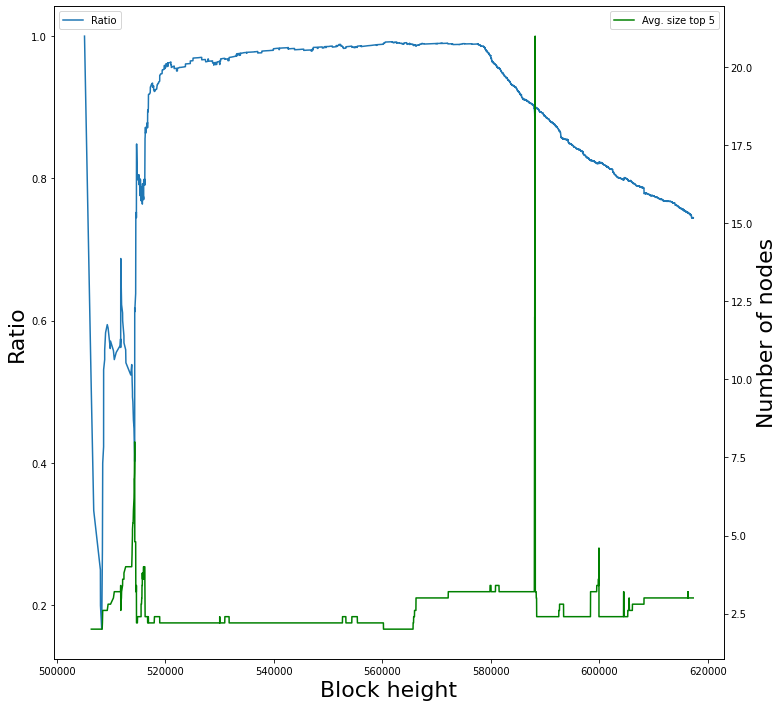

In [68]:
# TEST: Check correct save and size of connected component

mean_size=np.array([w for w,x,y,z in collection_output])
ratios=np.array([x for w,x,y,z in collection_output])
response_whole=np.array([y for w,x,y,z in collection_output])
response_connected=np.array([z for w,x,y,z in collection_output])

if (np.amin(response_whole)==200 and np.amax(response_whole)==200 and len(response_whole)==len(extraction_blocks)):
    print('Whole graphs saved succesfully')
else: 
    blocks_whole_error=np.take(np.array(blocks),np.where(response_whole != 200))
    print('The whole graphs from these blocks did not save correctly:{}'.format(blocks_whole_error))
    
if (np.amin(response_connected)==200 and np.amax(response_connected)==200):
    print('Connected graphs saved succesfully')
else: 
    blocks_whole_connected=np.take(np.array(blocks),np.where(response_connected != 200))
    print('The connected graphs from these blocks did not save correctly:{}'.format(blocks_whole_error))
    
# Check ratio of size fo connected to whole graphs
print('The ratio of connected to whole graphs for the export was: {}'.format(np.array(ratios).mean()))

# Print extraction_id
print('Extraction id: {}'.format(extraction_id))

# Print size for average size of 

#Visualize evolution of ratios

# Visualize evolutio of size

fig,ax1=plt.subplots(figsize=(12,12))
ax1.plot(extraction_blocks, ratios)
ax1.legend(['Ratio'], loc='upper left')
ax1.set_ylabel('Ratio',size=22)
ax1.set_xlabel('Block height',size=22)
ax2=ax1.twinx()
ax2.plot(extraction_blocks, mean_size,color='green')
ax2.set_ylabel('Number of nodes',size=22)
ax2.legend(['Avg. size top 5'], loc='upper right')



**FUNCTION: Validate Graphs sizes  and ratios of consecutive blocks**

In [51]:
"""
Function
--------
validate_consblocks
    Prints number of nodes and ratios of two consecutive blocks

Parameters
----------
    
bucket: str
    Name of S3 bucket to save graphs

    
extraction_id: int
    Epoch timestamp for extraction
    
ratios: list
    List of ratios for the extraction (output from generate collection function)
    
ix_extraction_block: int
    Index of block in extraction_blocks list
    
block1: int
    Block to perform validation
        
block2: int
    Block consecutive to block1
    

    
Returns
-------
G1: NetworkX graph
    Graph saved for block1 in S3

G2: NetworkX graph
    Graph saved for block2 in S3

G1_con: NetworkX graph
    Connected component graph for block1 saved in S3
    
G2_con: NetworkX graph
    Connected component graph for block2 saved in S3
        
 
"""


def validate_consblocks(bucket,extraction_id,ratios,ix_extraction_block,block1,block2):
    
    # Load two saved graphs and connected graphs (CHANGE EXTRACTION ID IN KEYS)
    key_base='graph_snapshots/'+str(extraction_id)+'/'
    key_con_base='graph_snapshots/'+str(extraction_id)+'_connected/'
    G1=load_graph(bucket,key_base+str(block1)+'.gpickle')
    G1_con=load_graph(bucket,key_con_base+str(block1)+'.gpickle')
    G2=load_graph(bucket,key_base+str(block2)+'.gpickle')
    G2_con=load_graph(bucket,key_con_base+str(block2)+'.gpickle')

    # Check ratios in blocks
    print('Ratio Block 1: {}'.format(ratios[ix_extraction_block]))
    print('Ratio Block 2: {}'.format(ratios[ix_extraction_block+1]))

    # Check nodes in graphs
    nodes_G1=list(G1.nodes())
    nodes_G1_con=list(G1_con.nodes())
    print('Number of nodes in G1: {}'.format(len(nodes_G1)))
    print('Number of nodes in G1_con: {}'.format(len(nodes_G1_con)))


    nodes_G2=list(G2.nodes())
    nodes_G2_con=list(G2_con.nodes())
    print('Number of nodes in G2: {}'.format(len(nodes_G2)))
    print('Number of nodes in G2_con: {}'.format(len(nodes_G2_con)))
    
    return G1,G2,G1_con,G2_con


**FUNCTION: Test correct graph formation based on previous graph**

In [52]:
"""
Function
--------
test_consgraph
    Test that channel opens and closures have been done correctly in 2 consecutive blocks

Parameters
----------
dec_tuple: tuple
    Tuple with decision dictionaries (opens closes) for the second block in the consecutive list
    
block1: int
    Block to perform validation
        
block2: int
    Block consecutive to block1
    
G1: NetworkX graph
    Graph for block1

G2: NetworkX graph
    Graph for block2
    
    
Returns
-------
tests: list
    List of lists. Each list per decision type (opens/closures) representing the test outcomes for each decision. 
        
 
"""


def test_consgraph(dec_tuple,block1,block2,G1,G2):

    dec_types=['opens','closures']
    dec_op=[1,-1]
    tests=[[],[]]
    
    for i in range(len(dec_tuple)):
    
        block_additions={}

        # Create dictionary with aggregate decisions for same pairs in block

        for channel in dec_tuple[i][block2]:
            node_pair=channel[0]*channel[1]

            if node_pair in block_additions:
                new_capacity=block_additions[node_pair]['capacity']+channel[2]['capacity']
                new_channels=block_additions[node_pair]['no_channels']+1

                block_additions[node_pair]={'capacity':new_capacity,'no_channels':new_channels}

            else:
                block_additions[node_pair]={'capacity':channel[2]['capacity'],'no_channels':1}
            

        # For each decision, check that it has been correctly created (this could be improved by only checking node pares and saving factorization in dic)

        for channel in dec_tuple[i][block2]:

            node_pair=channel[0]*channel[1]

            # If edge existed check that capacity increased by open amount
            
            if dec_types[i]=='opens':
            
            
                if G1.has_edge(channel[0],channel[1]):

                    change='Edit'

                    new_cap=G2.edges[channel[0],channel[1]]['capacity']
                    cap_change=G1.edges[channel[0],channel[1]]['capacity']+dec_op[i]*block_additions[node_pair]['capacity']

                    new_channels=G2.edges[channel[0],channel[1]]['no_channels']
                    channel_change=G1.edges[channel[0],channel[1]]['no_channels']+dec_op[i]*block_additions[node_pair]['no_channels']

                    if new_cap==cap_change and new_channels==channel_change:
                        status=1

                    else:
                        status=0

                # If edge did NOT extist check that it was added/removed

                else:
                    change='Add/Remove'

                    if G2.has_edge(channel[0],channel[1]):
                        status=1
                    else:
                        status=0
                    
                            
            elif dec_types[i]=='closures':
                
                if G1.edges[channel[0],channel[1]]['no_channels']>block_additions[node_pair]['no_channels']:
                    
                    change='Edit'

                    new_cap=G2.edges[channel[0],channel[1]]['capacity']
                    cap_change=G1.edges[channel[0],channel[1]]['capacity']+dec_op[i]*block_additions[node_pair]['capacity']

                    new_channels=G2.edges[channel[0],channel[1]]['no_channels']
                    channel_change=G1.edges[channel[0],channel[1]]['no_channels']+dec_op[i]*block_additions[node_pair]['no_channels']

                    if new_cap==cap_change and new_channels==channel_change:
                        status=1

                    else:
                        status=0
                else:
                    change='Add/Remove'
                    if not G2.has_edge(channel[0],channel[1]):
                        status=1
                    else:
                        status=0
                    

            tests[i].append((change,status))

        status_list=[s for c,s in tests[i]]

        # Check if it passes all tests

        if np.array(status_list).sum()==len(dec_tuple[i][block2]):
            print('All channel {} passed tests: {}'.format(dec_types[i],tests[i]))
        else:
            print('Some channel {} did NOT pass tests: {}'.format(dec_types[i],tests[i]))
    return tests

        

**SCRIPT: Test for random block**

In [54]:
# Select Blocks
# Select a block at random from the extraction and its consecutive block
# UNCOMMENT FOR RANDOM
random_ix=random.randint(0,len(extraction_blocks))
random_block_ix=init_block_ix+random_ix
block1=blocks[random_block_ix]
block2=blocks[random_block_ix+1]


print('Block 1: {}'.format(block1))
print('Block 2: {}'.format(block2))

print('Channel opens block 2: {}'.format(channel_opens[block2]))
print('Channel closures block 2: {}'.format(channel_closures[block2]))



Block 1: 564973
Block 2: 564975
Channel opens block 2: [(4504, 6158, {'capacity': 2000000, 'open_fee': 1984, 'dec_id': 15414, 'channel_id': '564975x1384x1', 'no_channels': 0})]
Channel closures block 2: []


In [55]:
# Validate consecutive block data
rb_G1,rb_G2,rb_G1_con,rb_G2_con=validate_consblocks(bucket,extraction_id,ratios,random_ix,block1,block2)

Ratio Block 1: 0.9893014474512272
Ratio Block 2: 0.9893014474512272
Number of nodes in G1: 3178
Number of nodes in G1_con: 3144
Number of nodes in G2: 3178
Number of nodes in G2_con: 3144


In [56]:
# Test channel updates
dec_tuple=(channel_opens,channel_closures)
rb_tests=test_consgraph(dec_tuple,block1,block2,rb_G1,rb_G2)


All channel opens passed tests: [('Add/Remove', 1)]
All channel closures passed tests: []


**SCRIPT: Test for block that has opens and closes**

In [57]:
# Select Blocks
# Select a block at random from the extraction and its consecutive block
# UNCOMMENT FOR RANDOM
block2=593936
block1=extraction_blocks[list(extraction_blocks).index(block2)-1]
random_ix=list(extraction_blocks).index(block1)
random_block_ix=init_block_ix+random_ix

# Print blocks and opens/closures
print('Block 1: {}'.format(block1))
print('Block 2: {}'.format(block2))

print('Channel opens block 2: {}'.format(channel_opens[block2]))
print('Channel closures block 2: {}'.format(channel_closures[block2]))

Block 1: 593931
Block 2: 593936
Channel opens block 2: [(5175, 2254, {'capacity': 16777215, 'open_fee': 170, 'dec_id': 53000, 'channel_id': '593936x2614x0', 'no_channels': 0})]
Channel closures block 2: [(4727, 1284, {'close_type': 'mutual', 'dec_id': 29810, 'channel_id': '573918x2492x1', 'capacity': 5000000}), (1363, 4727, {'close_type': 'unused', 'dec_id': 22573, 'channel_id': '567456x668x0', 'capacity': 500000}), (7479, 4727, {'close_type': 'unused', 'dec_id': 13496, 'channel_id': '563945x2028x0', 'capacity': 100000}), (5362, 4727, {'close_type': 'unused', 'dec_id': 11434, 'channel_id': '562821x415x1', 'capacity': 100000}), (2992, 4727, {'close_type': 'unused', 'dec_id': 11016, 'channel_id': '562479x329x0', 'capacity': 9995380}), (4727, 740, {'close_type': 'mutual', 'dec_id': 7929, 'channel_id': '558559x985x1', 'capacity': 9000000}), (4727, 5950, {'close_type': 'unused', 'dec_id': 5203, 'channel_id': '554453x545x0', 'capacity': 400000})]


In [58]:
# Validate consecutive block data
t1_G1,t1_G2,t1_G1_con,t1_G2_con=validate_consblocks(bucket,extraction_id,ratios,random_ix,block1,block2)

Ratio Block 1: 0.8544616397760948
Ratio Block 2: 0.8544616397760948
Number of nodes in G1: 6074
Number of nodes in G1_con: 5190
Number of nodes in G2: 6074
Number of nodes in G2_con: 5190


In [59]:
# Test channel updates
dec_tuple=(channel_opens,channel_closures)
rb_tests=test_consgraph(dec_tuple,block1,block2,t1_G1,t1_G2)

All channel opens passed tests: [('Add/Remove', 1)]
All channel closures passed tests: [('Add/Remove', 1), ('Add/Remove', 1), ('Add/Remove', 1), ('Add/Remove', 1), ('Add/Remove', 1), ('Add/Remove', 1), ('Add/Remove', 1)]


**SCRIPT: Test for block that has edit opens and edit closures**

In [60]:
# Select Blocks
# Select a block at random from the extraction and its consecutive block
# UNCOMMENT FOR RANDOM
block2=592373
block1=extraction_blocks[list(extraction_blocks).index(block2)-1]
random_ix=list(extraction_blocks).index(block1)
random_block_ix=init_block_ix+random_ix

# Print blocks and opens/closures
print('Block 1: {}'.format(block1))
print('Block 2: {}'.format(block2))

print('Channel opens block 2: {}'.format(channel_opens[block2]))
print('Channel closures block 2: {}'.format(channel_closures[block2]))

Block 1: 592372
Block 2: 592373
Channel opens block 2: [(6568, 3184, {'capacity': 256000, 'open_fee': 154, 'dec_id': 51016, 'channel_id': '592373x1625x0', 'no_channels': 0}), (6568, 3184, {'capacity': 256000, 'open_fee': 154, 'dec_id': 51015, 'channel_id': '592373x1624x0', 'no_channels': 0}), (6568, 3184, {'capacity': 256000, 'open_fee': 154, 'dec_id': 51014, 'channel_id': '592373x1623x1', 'no_channels': 0}), (6568, 3184, {'capacity': 256000, 'open_fee': 291, 'dec_id': 51001, 'channel_id': '592373x1301x1', 'no_channels': 0}), (6568, 3184, {'capacity': 256000, 'open_fee': 154, 'dec_id': 51011, 'channel_id': '592373x1620x1', 'no_channels': 0}), (6568, 3184, {'capacity': 256000, 'open_fee': 154, 'dec_id': 51004, 'channel_id': '592373x1613x1', 'no_channels': 0}), (6568, 3184, {'capacity': 256000, 'open_fee': 154, 'dec_id': 51003, 'channel_id': '592373x1612x1', 'no_channels': 0}), (6568, 3184, {'capacity': 256000, 'open_fee': 223, 'dec_id': 51002, 'channel_id': '592373x1411x0', 'no_channels

In [64]:
# Validate consecutive block data
t2_G1,t2_G2,t2_G1_con,t2_G2_con=validate_consblocks(bucket,extraction_id,ratios,random_ix,block1,block2)

Ratio Block 1: 0.7524739411531864
Ratio Block 2: 0.7526058846813564
Number of nodes in G1: 7579
Number of nodes in G1_con: 5703
Number of nodes in G2: 7579
Number of nodes in G2_con: 5704


In [62]:
# Test channel updates
dec_tuple=(channel_opens,channel_closures)
rb_tests=test_consgraph(dec_tuple,block1,block2,t2_G1,t2_G2)

All channel opens passed tests: [('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1)]
All channel closures passed tests: []


**SCRIPT: Test for block that has edits on opens and closures**

In [65]:
# Select Blocks
# Select a block at random from the extraction and its consecutive block
# UNCOMMENT FOR RANDOM
block2=616163
block1=extraction_blocks[list(extraction_blocks).index(block2)-1]
random_ix=list(extraction_blocks).index(block1)
random_block_ix=init_block_ix+random_ix

# Print blocks and opens/closures
print('Block 1: {}'.format(block1))
print('Block 2: {}'.format(block2))

print('Channel opens block 2: {}'.format(channel_opens[block2]))
print('Channel closures block 2: {}'.format(channel_closures[block2]))

Block 1: 616162
Block 2: 616163
Channel opens block 2: [(6367, 288, {'capacity': 2000000, 'open_fee': 154, 'dec_id': 70771, 'channel_id': '616163x2542x0', 'no_channels': 0}), (3016, 7524, {'capacity': 500000, 'open_fee': 222, 'dec_id': 70767, 'channel_id': '616163x2496x1', 'no_channels': 0}), (1292, 7597, {'capacity': 3000000, 'open_fee': 15124, 'dec_id': 70764, 'channel_id': '616163x1106x0', 'no_channels': 0}), (2821, 7524, {'capacity': 600000, 'open_fee': 223, 'dec_id': 70766, 'channel_id': '616163x2495x0', 'no_channels': 0}), (4118, 5553, {'capacity': 20000, 'open_fee': 155, 'dec_id': 70768, 'channel_id': '616163x2539x0', 'no_channels': 0}), (7314, 4000, {'capacity': 300000, 'open_fee': 154, 'dec_id': 70769, 'channel_id': '616163x2540x1', 'no_channels': 0}), (7259, 6860, {'capacity': 16777215, 'open_fee': 154, 'dec_id': 70772, 'channel_id': '616163x2543x0', 'no_channels': 0}), (4998, 2107, {'capacity': 31337, 'open_fee': 154, 'dec_id': 70773, 'channel_id': '616163x2544x0', 'no_chann

In [66]:
# Validate consecutive block data
t3_G1,t3_G2,t3_G1_con,t3_G2_con=validate_consblocks(bucket,extraction_id,ratios,random_ix,block1,block2)

Ratio Block 1: 0.7524739411531864
Ratio Block 2: 0.7526058846813564
Number of nodes in G1: 7579
Number of nodes in G1_con: 5703
Number of nodes in G2: 7579
Number of nodes in G2_con: 5704


In [67]:
# Test channel updates
dec_tuple=(channel_opens,channel_closures)
rb_tests=test_consgraph(dec_tuple,block1,block2,t3_G1,t3_G2)

All channel opens passed tests: [('Add/Remove', 1), ('Add/Remove', 1), ('Add/Remove', 1), ('Add/Remove', 1), ('Add/Remove', 1), ('Add/Remove', 1), ('Edit', 1), ('Add/Remove', 1), ('Edit', 1), ('Add/Remove', 1)]
All channel closures passed tests: [('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1), ('Edit', 1)]


**TEST: DataFrame**

In [265]:
#df[df['node_pair']==3381624].sort_values(by=['close_block'],ascending=True).head(40)
#df.head()

,short_channel_id,open_block,open_transaction,address,close_block,close_transaction,node0,node1,satoshis,last_seen,...,close_fee,last_update,close_type,close_htlc_count,close_balance_a,close_balance_b,dec_id,node0_id,node1_id,node_pair
51012,592373x1621x1,592373,625110e63973ae0ca90c6f66c74ec235ed1d1818c250fb...,bc1q9yk90y060gw4egmn7rq8ysdls9pvkrg77ljykak67p...,594232.0,7041f58e98c905ce7c5993c08a606214e15e335c9ff306...,02529db69fd2ebd3126fb66fafa234fc3544477a23d509...,03e28800c579c3d0c3a728742c016cb329e5a5ff256dd3...,256000,2019-09-10 06:20:49,...,6245.0,1.568041e+09,force,0.0,249755.0,0.0,51012,6309,536,3381624
50988,592368x1050x1,592368,1fa3657c7642141c741039d983eac4c69f53a209bcae7a...,bc1qz452wcfu08kxgzjg6pg7czwzsk9t754v8vs3xveh4n...,607519.0,094f5048bbd53e82c885f2976e110ee4dd8d895be0f4b4...,02529db69fd2ebd3126fb66fafa234fc3544477a23d509...,03e28800c579c3d0c3a728742c016cb329e5a5ff256dd3...,256000,2019-12-10 05:20:58,...,2149.0,1.575629e+09,force,0.0,253851.0,0.0,50988,6309,536,3381624
51047,592431x2297x1,592431,438014ef4be1ffc6d4dc857581037604f37abc651ea496...,bc1qchrqd89yum7crxk8sg57e3ur86wdj2v96cwu4xgp52...,616163.0,12d281cc7e3a92cac880b9ac39d4cc1236637477f71add...,02529db69fd2ebd3126fb66fafa234fc3544477a23d509...,03e28800c579c3d0c3a728742c016cb329e5a5ff256dd3...,256000,2020-02-05 05:01:26,...,138.0,1.580492e+09,unused,0.0,255862.0,0.0,51047,6309,536,3381624
51046,592431x2295x1,592431,ed0564021fbe7f9a9b92749ce8f139b01bf9f9c0681791...,bc1qhjkxtz52vgzxzzvtppklrwyjyjcf0tzcf6mp0tfx9y...,616163.0,bda75839dd7165d8bed81b03d34cce567b8a9c9520bd46...,02529db69fd2ebd3126fb66fafa234fc3544477a23d509...,03e28800c579c3d0c3a728742c016cb329e5a5ff256dd3...,256000,2020-02-05 05:01:26,...,138.0,1.580492e+09,unused,0.0,255862.0,0.0,51046,6309,536,3381624
51014,592373x1623x1,592373,8bf40336d980cd92b8de1bac0595df3a3bdf53d25bb37d...,bc1q07t9rqykktps3dftluw0s7xuycmrf48ndd7galexj5...,616163.0,3112f8d315056f7db256154815089ccb8425b6ec044d5e...,02529db69fd2ebd3126fb66fafa234fc3544477a23d509...,03e28800c579c3d0c3a728742c016cb329e5a5ff256dd3...,256000,2020-02-05 05:01:17,...,138.0,1.580492e+09,unused,0.0,255862.0,0.0,51014,6309,536,3381624
50989,592368x1105x0,592368,75fa19eed704c520383ca11330d3c1a2b00c5ce65e2b31...,bc1q5mmv22jvtteqgh5p809xw5u3sexu7tt9pu6j26g8qq...,616163.0,352df626c77abb029c0101e8daefce0ea79ee59b2f54f1...,02529db69fd2ebd3126fb66fafa234fc3544477a23d509...,03e28800c579c3d0c3a728742c016cb329e5a5ff256dd3...,256000,2020-02-05 05:00:54,...,138.0,1.580492e+09,unused,0.0,255862.0,0.0,50989,6309,536,3381624
51149,592510x2306x0,592510,a6c90d2b74979be91b679c9abd70e0366442d52ae70f3d...,bc1qdg883r3pkp7d8dppnhdfnp6f3zwafl29scf2a6adty...,616163.0,8efd88e4f40b82772400777a7f962040e920a58f032597...,02529db69fd2ebd3126fb66fafa234fc3544477a23d509...,03e28800c579c3d0c3a728742c016cb329e5a5ff256dd3...,202000,2020-02-05 05:01:58,...,138.0,1.580492e+09,unused,0.0,201862.0,0.0,51149,6309,536,3381624
51171,592511x862x1,592511,051bb464491aa6edd9b9a765886149eaa3a6c79454e401...,bc1q6jvn6kvk4elp7fa0qkzzxrruke5nke0ujvm98wzd2z...,616164.0,1715a4ded9db7698bab62462072f913b0b6939639ab26e...,02529db69fd2ebd3126fb66fafa234fc3544477a23d509...,03e28800c579c3d0c3a728742c016cb329e5a5ff256dd3...,202000,2020-02-05 05:02:10,...,138.0,1.580492e+09,unused,0.0,201862.0,0.0,51171,6309,536,3381624
51170,592511x733x0,592511,659e2600508eaef700f555a6cec496d7f2e2b206a048e6...,bc1ql8ga5j67dq0tquzpfejx9y6lq4xpgmaj8gsuwwmntd...,616164.0,bfab2caee5265925e2c7d6bf7bbf42a38e025983650658...,02529db69fd2ebd3126fb66fafa234fc3544477a23d509...,03e28800c579c3d0c3a728742c016cb329e5a5ff256dd3...,202000,2020-02-05 05:02:09,...,138.0,1.580492e+09,unused,0.0,201862.0,0.0,51170,6309,536,3381624
51016,592373x1625x0,592373,e5001dbb211ce4c0098eb1f90c85317b642517ba2a9338...,bc1q0pgvhkrkg5e88uq7tkcpvxefm496gyyu4f6fz6zjl7...,616164.0,39ca4693c1aaf9ee829bcacd61c6bdb8b96d5bb707062a...,02529db69fd2ebd3126fb66fafa234fc3544477a23d509...,03e28800c579c3d0c3a728742c016cb329e5a5ff256dd3...,256000,2020-02-05 05:01:18,...,13

In [70]:
key='graph_snapshots/'+str(extraction_id)+'_connected/616163.gpickle'

g_test=load_graph(bucket,key)


In [71]:
g_test.edges[6367, 288]['capacity']

2000000

In [74]:
g_test.edges[6367, 288]['capacity']-=1000000

In [75]:
g_test.edges[6367, 288]['capacity']

2000000

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


### Utility functions

In [41]:

"""
Function
--------
load_graph
    Loads networkX (pickle serialized) object from S3

Parameters
----------
bucket: str
    S3 bucket name

key : str
    Path in S3 bucket for individual pickled serialized networkX graph object 

    
Returns
-------
response: networkX graph
    Graph object
 
"""

def load_graph(bucket,key):
    session = boto3.session.Session()
    s3 = session.resource('s3')
    response = s3.Object(bucket_name=bucket, key=key).get()
    G=pickle.loads(response['Body'].read())
    
    return G

In [24]:
# Function to write pickle data to S3 bucket

"""
Function
--------
pickle_save_s3
    Saves Python object to S3 as pickle object

Parameters
----------
obj : <any>
    Python Object

bucket: str
    Name of S3 bucket to save
    
key: str
    path to save
    
file_type: str
    'pickle' or 'csv' to indicate type of save


    
Returns
-------
response: int
    HTTP response code from S3 
 
"""


def save_s3(obj,bucket,key,file_type):

    # Load S3 and bucket details
    session = boto3.session.Session()
    s3 = session.resource('s3')

    if file_type=='pickle':
    
        # Create pickle object 
        byte_obj = pickle.dumps(obj) 
        response=s3.Object(bucket,key).put(Body=byte_obj)
        
        
    elif file_type=='csv':
    
        # Create byte object
        csv_buffer = io.StringIO()
        df_copy=obj
        df_copy.to_csv(csv_buffer)
        response=s3.Object(bucket,key).put(Body=csv_buffer.getvalue())
    
    return response['ResponseMetadata']